# Fink case study: extragalactic science

<img src="../Fink_PrimaryLogo_WEB.jpg" width=300 />

## Goal

The goal of this notebook is to show how Fink can contribute to extragalactic science. This notebook includes queries for **Active Galactic Nucleii** and **Supernova** science. 

## What is behind?

This notebook will use:
- **Fink cross-match** with close by sources in the SIMBAD catalogue (within 1'') using xmatch service provided by the Centre de Données astronomiques de Strasbourg (CDS).
- **Fink's machine learning classification** scores 
    - [SuperNNova](https://github.com/supernnova/SuperNNova) [(Möller & de Boissière 2019)](https://academic.oup.com/mnras/article-abstract/491/3/4277/5651173) for all light-curves
    - Random Forest (Leoni et al. in prep) and [(Ishida et al. 2019b)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.483....2I/abstract) for early (pre-max) light-curves
- **Fink's extra features** such as color "r-g" when possible.

# 1st case study: known AGNs

### <font color='blue'>API query:</font> <font color='orange'> latest alerts</font> associated with known AGNs
Query latest n=5 alerts spatially coincident with a catalogued AGN in the CDS Simbad catalogue

In [1]:
import requests
import pandas as pd

# Get latests 100 alerts linked to AGNs
r = requests.post(
  'http://134.158.75.151:24000/api/v1/latests',
  json={
    'class': 'AGN', # tag from CDSxmatch service
    'n': '5' # number of alerts
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

This table contains all alerts linked to a CDS catalogue AGN. This includes
- Alert information from ZTF processing (just latest photometry points).
- Fink's added values.

In [2]:
pdf

,d:cdsxmatch,d:knscore,d:mulens_class_1,d:mulens_class_2,d:rfscore,d:roid,d:snn_sn_vs_all,d:snn_snia_vs_nonia,i:candid,i:chipsf,...,i:ssdistnr,i:ssmagnr,i:ssnamenr,i:tooflag,i:xpos,i:ypos,v:classification,v:r-g,v:rate(r-g),v:lastdate
0,AGN,0,,CONSTANT,0.063,0,0.857455,0.007269,1554507473015015009,2.664880,...,-999,-999,null,0,1256.1070,2466.9817,AGN,NaN,NaN,2021-04-04 12:10:46.004
1,AGN,0,,VARIABLE,0.100,0,0.187933,0.930695,1554503406015010006,3.018314,...,-999,-999,null,0,1223.7240,301.4202,AGN,NaN,NaN,2021-04-04 12:04:54.002
2,AGN,0,,,0.134,0,0.438135,0.722683,1554503403615015005,7.434546,...,-999,-999,null,0,2472.0237,1012.0659,AGN,NaN,NaN,2021-04-04 12:04:54.002
3,AGN,0,,,0.066,0,0.864960,0.866059,1554494203315010004,54.948658,...,-999,-999,null,0,3057.5479,841.4135,AGN,NaN,NaN,2021-04-04 11:51:39.001
4,AGN,0,,,0.046,0,0.846829,0.815313,1554494205215010006,3.074030,...,-999,-999,null,0,1680.8989,1612.2079,AGN,NaN,NaN,2021-04-04 11:51:39.001


Get objects Ids associated to these latest 100 alerts associated to AGNs in ZTF.

In [3]:
recent_AGN_objectIds = pdf['i:objectId'].unique()

### <font color='blue'>API query:</font> get <font color='orange'> photometry </font> for one of these AGNs

In [4]:
# import requests
# import pandas as pd
r = requests.post(
  'http://134.158.75.151:24000/api/v1/objects',
  json={
    'objectId': recent_AGN_objectIds[1],
    'output-format': 'json'
  }
)

# Format output in a DataFrame
single_object = pd.read_json(r.content)

### <font color='blue'>Analysing the output:</font> plot the light-curve for visualization

In [5]:
import matplotlib.pyplot as plt
dic_flt = {1:"g", 2:"r", 3:"i"}
filter_color = {1: '#1f77b4', 2: '#ff7f0e', 3: '#2ca02c'}
for flt in [1,2]:
    df_byflt = single_object[single_object['i:fid']==flt]
    plt.errorbar(df_byflt['i:jd'], df_byflt['i:magpsf'], yerr=df_byflt['i:sigmapsf'],fmt='o',label=dic_flt[flt])
plt.xlabel('jd')
plt.ylabel('magpsf')
plt.legend()
plt.gca().invert_yaxis()

# 2nd case study: early supernovae candidates
**Early supernova candidates is a tag defined and provided by Fink.** 
It requires that the alert has no known transient association (from catalogues), it is relatively new (number of previous detections < 10) and when both a [SuperNNova](https://github.com/supernnova/SuperNNova) [(Möller & de Boissière 2019)](https://academic.oup.com/mnras/article-abstract/491/3/4277/5651173) trained to identify SNe Ia or SNe and a Random Forest (Leoni et al. in prep.) based on [(Ishida et al. 2019b)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.483....2I/abstract) trained to select early supernovae have a probability higher than 50% of this object being a SN.

### <font color='blue'>API query:</font>   <font color='orange'>latest alerts </font>  tagged as early supernovae candidates

In [6]:
# Get latests 5 Early SN candidates
r = requests.post(
  'http://134.158.75.151:24000/api/v1/latests',
  json={
    'class': 'Early SN candidate',
    'n': '50'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

### <font color='blue'>Analysing the output:</font>   <font color='orange'>color</font>  of these alerts (if g and r measurements in the same night)
This color is an added value by Fink if there is photmetry in a single night for two filters

In [7]:
candSNe_w_color = pdf[(~pdf["v:r-g"].isna())]
candSNe_w_color[candSNe_w_color.columns[::-1]][:5]

,v:lastdate,v:rate(r-g),v:r-g,v:classification,i:ypos,i:xpos,i:tooflag,i:ssnamenr,i:ssmagnr,i:ssdistnr,...,i:chipsf,i:candid,d:snn_snia_vs_nonia,d:snn_sn_vs_all,d:roid,d:rfscore,d:mulens_class_2,d:mulens_class_1,d:knscore,d:cdsxmatch
0,2021-04-04 06:29:04.001,NaN,-0.066378,Early SN candidate,1867.1654,1051.4908,0,null,-999,-999,...,8.427642,1554270180115015019,0.864539,0.528316,0,0.634,,,0,Unknown
1,2021-04-04 06:24:58.003,-0.014601,0.036086,Early SN candidate,2486.4917,1682.4648,0,null,-999,-999,...,33.910720,1554267334315015031,0.858366,0.454975,0,0.927,,,0,Unknown
3,2021-04-04 05:40:13.996,NaN,0.382109,Early SN candidate,680.5980,1951.5391,0,null,-999,-999,...,2.188631,1554236272615015005,0.725744,0.970131,0,0.793,,,0,Unknown
5,2021-04-04 05:05:20.999,NaN,0.270320,Early SN candidate,1242.3706,1915.6570,0,null,-999,-999,...,32.727510,1554212045615015011,0.840251,0.737839,0,0.962,,,0,Unknown
6,2021-04-04 04:43:44.999,-0.007655,0.131540,Early SN candidate,1956.4037,1037.5734,0,null,-999,-999,...,69.294914,1554197043915015011,0.872069,0.339726,0,0.959,,,0,Unknown


Text(0.5, 0, 'v:r-g')

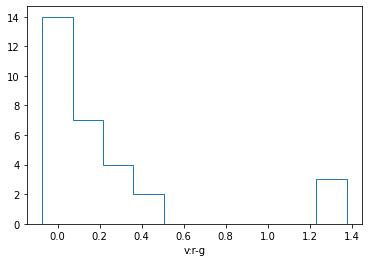

In [8]:
plt.hist(candSNe_w_color["v:r-g"], histtype='step')
plt.xlabel("v:r-g")

### <font color='blue'>Analysing the output:</font>   <font color='orange'>"bluer" color</font>  (e.g. r-g<0)

In [9]:
color_selected = candSNe_w_color[candSNe_w_color["v:r-g"]<0]
color_selected[['i:objectId',"v:r-g"]]

,i:objectId,v:r-g
0,ZTF21aappktx,-0.066378
16,ZTF21aaqgrrf,-0.036692
17,ZTF21aaqgrrf,-0.036692
20,ZTF21aaqkqwq,-0.073208
21,ZTF21aappktx,-0.066378
23,ZTF21aaqkqwq,-0.073208
25,ZTF21aappktx,-0.066378
44,ZTF21aaqgrrf,-0.036692
45,ZTF21aappktx,-0.066378
48,ZTF21aaqkqwq,-0.073208


### <font color='blue'>Analysing the output:</font>   <font color='orange'>"bluer" brighter</font>    select alerts with given color and brighter than magpsf 19 (either filter)
this is the latest measured magnitude, not a projection

In [10]:
bright_candSNe_w_color = color_selected[(color_selected["i:magpsf"]<19)]
bright_candSNe_w_color[["i:objectId","i:magpsf","v:r-g"]]

,i:objectId,i:magpsf,v:r-g
0,ZTF21aappktx,18.460170,-0.066378
16,ZTF21aaqgrrf,18.609120,-0.036692
17,ZTF21aaqgrrf,18.605534,-0.036692
20,ZTF21aaqkqwq,18.856342,-0.073208
21,ZTF21aappktx,18.388426,-0.066378
23,ZTF21aaqkqwq,18.735836,-0.073208
25,ZTF21aappktx,18.405067,-0.066378
44,ZTF21aaqgrrf,18.563020,-0.036692
45,ZTF21aappktx,18.274721,-0.066378
48,ZTF21aaqkqwq,18.979240,-0.073208


### <font color='blue'> API query:</font>   <font color='orange'>photometry</font>  for one high-probability alert with given color and brighter than magpsf 19 (either filter)
Supernova scores are obtained using SuperNNova trained in two different ways: 

In [11]:
prob_threshold = 0.8 # 80% confidence

In [12]:
high_prob_objs = bright_candSNe_w_color[(bright_candSNe_w_color['d:snn_sn_vs_all']>prob_threshold) | (bright_candSNe_w_color['d:snn_snia_vs_nonia']>prob_threshold)]

In [13]:
high_prob_obj = high_prob_objs.sort_values(by=['i:ndethist'])['i:objectId'].iloc[-1]

In [14]:
r = requests.post(
  'http://134.158.75.151:24000/api/v1/objects',
  json={
    'objectId': high_prob_obj,
    'output-format': 'json'
  }
)

# Format output in a DataFrame
single_object = pd.read_json(r.content)

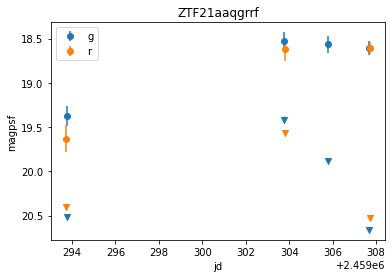

In [15]:
# import matplotlib.pyplot as plt
# dic_flt = {1:"g", 2:"r", 3:"i"}
# filter_color = {1: '#1f77b4', 2: '#ff7f0e', 3: '#2ca02c'}
for flt in [1,2]:
    df_byflt = single_object[single_object['i:fid']==flt]
    plt.errorbar(df_byflt['i:jd'], df_byflt['i:magpsf'], yerr=df_byflt['i:sigmapsf'],fmt='o',label=dic_flt[flt],color=filter_color[flt])
    plt.scatter(df_byflt['i:jd'],df_byflt['i:diffmaglim'],marker='v',color=filter_color[flt])
plt.xlabel('jd')
plt.ylabel('magpsf')
plt.title(single_object['i:objectId'][0])
plt.gca().invert_yaxis()
plt.legend()

# 3rd case study: spectroscopically classified (TNS) type Ia supernovae in Fink
Type Ia supernovae recently classified and reported in TNS.

### <font color='blue'> API query:</font>   <font color='orange'>latest alerts</font> associated with known type Ia SNe

In [16]:
# import requests
# import pandas as pd
# Get all objects classified as SN Ia in TNS between 2019/12/01 and 2019/12/15, with
# a maximum of n alerts search inside the database
r = requests.post(
  'http://134.158.75.151:24000/api/v1/latests',
  json={
    'class': '(TNS) SN Ia',  # TNS classification
    'n': '10',  # n alerts to query in database
    'startdate': '2020-12-01', # start TNS classification
    'stopdate': '2021-04-05',  # end TNS classification
  }
)
# Format output in a DataFrame
pdf = pd.read_json(r.content)
print(pdf['i:objectId'])

0    ZTF18abncdhd
1    ZTF18abcoxmc
2    ZTF18abvuceu
3    ZTF18acjxyak
4    ZTF21aamwzfi
5    ZTF21aafdxca
6    ZTF21aaqwjlz
7    ZTF21aaplooj
8    ZTF21aapvsxv
9    ZTF21aaplnxw
Name: i:objectId, dtype: object


### <font color='blue'> API query:</font>   <font color='orange'>photometry</font> of one known type Ia SNe

In [17]:
r = requests.post(
  'http://134.158.75.151:24000/api/v1/objects',
  json={
    'objectId': pdf['i:objectId'].iloc[-1],
    'output-format': 'json'
  }
)

# Format output in a DataFrame
single_object = pd.read_json(r.content)

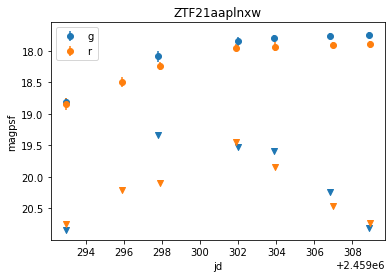

In [18]:
import matplotlib.pyplot as plt
dic_flt = {1:"g", 2:"r", 3:"i"}
filter_color = {1: '#1f77b4', 2: '#ff7f0e', 3: '#2ca02c'}
for flt in [1,2]:
    df_byflt = single_object[single_object['i:fid']==flt]
    plt.errorbar(df_byflt['i:jd'], df_byflt['i:magpsf'], yerr=df_byflt['i:sigmapsf'],fmt='o',label=dic_flt[flt],color=filter_color[flt])
    plt.scatter(df_byflt['i:jd'],df_byflt['i:diffmaglim'],marker='v',color=filter_color[flt])
plt.xlabel('jd')
plt.ylabel('magpsf')
plt.title(single_object['i:objectId'][0])
plt.gca().invert_yaxis()
plt.legend()

### <font color='blue'> Analising the output:</font>   <font color='orange'>Latest ML scores</font> associated with known type Ia SNe

fetch latest classification scores and plot their distribution

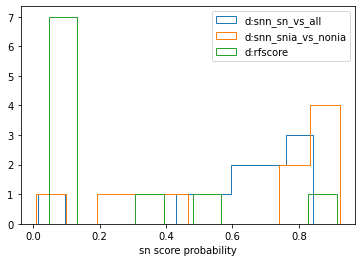

In [19]:
for score in ['d:snn_sn_vs_all','d:snn_snia_vs_nonia','d:rfscore']:
    plt.hist(pdf[score], histtype='step', label=score)
plt.xlabel('sn score probability')
plt.legend()

Note that:
- **'rfscore' is designed only for early SNe classification**, therefore it should not provide high scores for post-peak brightness SNe.
- some of these light-curves may not have the SN light anymore 

### <font color='blue'> Analising the output:</font>   <font color='orange'>SNe with close-by galaxies</font> (not necessarily their host-galaxies)

Fink cross-matches the alert to the closest source (within 1'' radius) in the SIMBAD xmatch service providing 'd:cdsxmatch' tag.

In [20]:
with_closeby_gal = pdf[pdf['d:cdsxmatch']=='Galaxy']

To analyze, we also use ZTF alert stream information of close neighbours
-'i:distnr': distance to nearest source in reference image PSF-catalog within 30 arcsec [pixels]
-'i:magnr': magnitude of nearest source in reference image PSF-catalog within 30 arcsec [mag]

In [21]:
with_closeby_gal[['i:objectId','i:distnr','i:magnr']]

,i:objectId,i:distnr,i:magnr
3,ZTF18acjxyak,0.669415,15.710999
7,ZTF21aaplooj,0.928013,16.910000


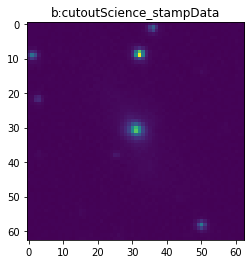

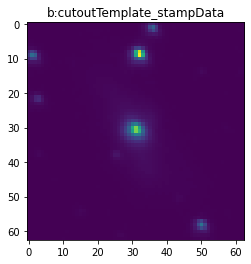

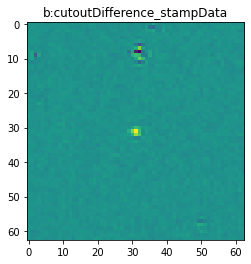

In [22]:
# import requests
# import pandas as pd
# import matplotlib.pyplot as plt

# transfer cutout data
r = requests.post(
  'http://134.158.75.151:24000/api/v1/objects',
  json={
    'objectId': with_closeby_gal['i:objectId'].iloc[0],
    'withcutouts': 'True'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

columns = [
    'b:cutoutScience_stampData',
    'b:cutoutTemplate_stampData',
    'b:cutoutDifference_stampData'
]

for col in columns:
    # 2D array
    data = pdf[col].values[0]

    # do whatever plotting
    plt.imshow(data)
    plt.title(col)
    plt.show()

# Summary
In this notebook we have searched for AGNs and SNe:
- Querying Fink's API for latest alerts using known catalogue types, e.g. from SIMBAD or TNS
- Querying Fink's API for candidate SNe selected using our ML algorithms 
- Filtering all of these alerts according to your science case
- Querying Fink's API for photometry and thumbnails for a given object.